In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [4]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/StockData/Apple.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'High']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

In [5]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# Tiến hành huấn luyện mô hình SARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['High']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

In [6]:
import pmdarima as pm
import statsmodels.api as sm

#Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình SARIMAX (đảm bảo rằng seasonal_order được đặt nếu bạn muốn sử dụng SARIMAX)
model_fit = SARIMAX(y_train, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3942.773, Time=2.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3937.244, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3935.618, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3935.454, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3937.471, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3933.697, Time=0.53 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3935.455, Time=0.88 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3937.455, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3935.405, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=3935.525, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3933.866, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3937.393, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=3934.361, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 7.055 seconds


In [7]:
x_test = np.array(test_data.index).reshape(-1, 1)

# Dự đoán trên tập kiểm thử (test_data)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['High']).reshape(-1, 1)
y_pred_test = model_fit.predict(start=train_size, end=train_size+len(test_data)-1, exog=exog_test)
y_pred_test

array([138.63788531, 133.19301429, 131.9101415 , 135.28870184,
       130.44120095, 131.11691654, 135.01450156, 135.70000421,
       136.51281896, 139.76408188, 141.31136691, 141.2428095 ,
       138.54975182, 136.29737337, 136.95349819, 139.47029084,
       141.92831215, 144.30800368, 145.28729738, 144.39613619,
       146.16865583, 144.21006843, 146.65830268, 148.52875757,
       149.22406197, 148.89109134, 151.32953756, 153.14123678,
       153.83652747, 152.62219741, 150.71257763, 154.8647888 ,
       155.16836691, 161.03434205, 160.99516149, 159.83960276,
       163.93304259, 164.52062469, 163.20837505, 165.12778287,
       163.17899721, 166.62610027, 168.24194369, 169.3975034 ,
       170.5922427 , 170.90562452, 173.29508842, 172.07097129,
       170.93500137, 167.13533789, 166.00915601, 165.42157391,
       167.40953817, 168.30069935, 160.31944688, 159.98649094,
       158.04749332, 155.93221501, 157.83204773, 154.62975243,
       154.21845104, 153.91487293, 155.34464761, 161.65

In [8]:
# Dự đoán giá 30 ngày tiếp theo

next_dates = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')

mean_volume = np.mean(df['High'])
exog_next = np.full((30, 1), mean_volume)
# Tính chỉ số bắt đầu và kết thúc cho dự đoán
start_index = len(df) - len(y_test)
end_index = len(df) - 1

# Tạo mảng exogenous kết hợp cho tập kiểm thử và 30 ngày tiếp theo
exog_combined = np.concatenate((exog_test, exog_next))

# Dự đoán cho tập kiểm thử và 30 ngày tiếp theo
y_pred_combined = model_fit.predict(start=train_size, end=train_size + len(test_data) + 29, exog=exog_combined)

# Tách phần dự đoán cho 30 ngày tiếp theo
y_pred_next_30_days = y_pred_combined[-30:]

# Chuẩn bị DataFrame cho đồ thị
next_30_days = pd.DataFrame({'Date': next_dates, 'Predicted_Close': y_pred_next_30_days})
y_pred_combined



array([138.63788531, 133.19301429, 131.9101415 , 135.28870184,
       130.44120095, 131.11691654, 135.01450156, 135.70000421,
       136.51281896, 139.76408188, 141.31136691, 141.2428095 ,
       138.54975182, 136.29737337, 136.95349819, 139.47029084,
       141.92831215, 144.30800368, 145.28729738, 144.39613619,
       146.16865583, 144.21006843, 146.65830268, 148.52875757,
       149.22406197, 148.89109134, 151.32953756, 153.14123678,
       153.83652747, 152.62219741, 150.71257763, 154.8647888 ,
       155.16836691, 161.03434205, 160.99516149, 159.83960276,
       163.93304259, 164.52062469, 163.20837505, 165.12778287,
       163.17899721, 166.62610027, 168.24194369, 169.3975034 ,
       170.5922427 , 170.90562452, 173.29508842, 172.07097129,
       170.93500137, 167.13533789, 166.00915601, 165.42157391,
       167.40953817, 168.30069935, 160.31944688, 159.98649094,
       158.04749332, 155.93221501, 157.83204773, 154.62975243,
       154.21845104, 153.91487293, 155.34464761, 161.65

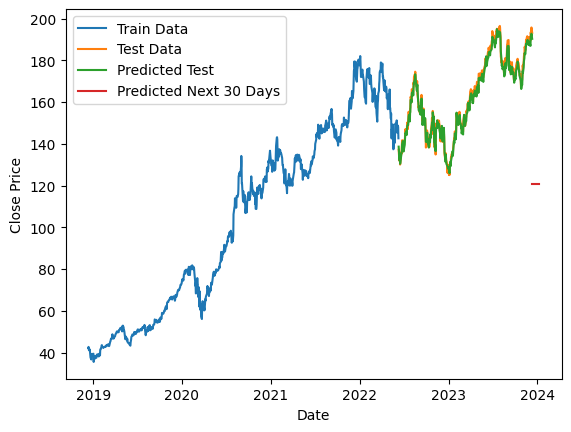

In [9]:
# Vẽ đồ thị
#plt.figure(figsize=(15, 8))
plt.plot(train_data['Date'], train_data['Close'], label='Train Data')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data')
plt.plot(test_data['Date'], y_pred_test, label='Predicted Test')
plt.plot(next_30_days['Date'], next_30_days['Predicted_Close'], label='Predicted Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [10]:
# Tính MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Tính toán RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Làm tròn đến số thứ 3 sau dấu phẩy
test_mae = round(test_mae, 3)
test_rmse = round(test_rmse, 3)
test_mape = round(test_mape, 3)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 1.625
Testing RMSE: 1.849
Testing MAPE: 0.992


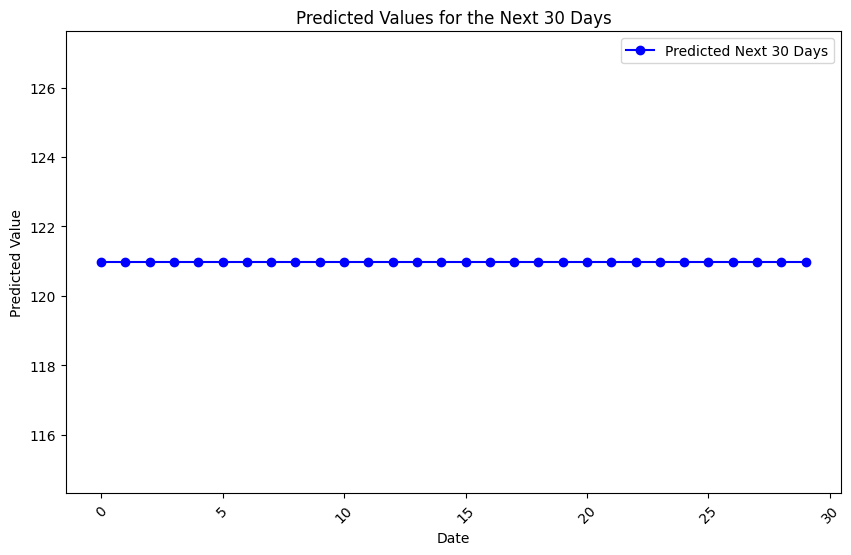

In [11]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(y_pred_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()


